# Parallelized Simulation of NBA Seasons Using Markov Chains and Possession-Level Transition Modeling

By Trenton Smiley Jr

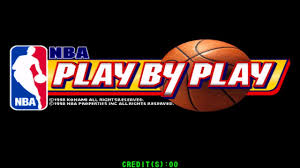

Image from: https://www.youtube.com/watch?v=PTceexRf8Js

---
# Abstract

This project explores the application of parallel computing to simulate NBA seasons using team-specific transition behavior derived from empirical play-by-play data. Rooted in sports analytics, the project leverages historical basketball data to model possession-level decision-making via Markov chains. I selected this domain due to a strong interest in both basketball and predictive modeling, and the challenge of using real-world, noisy data to build interpretable simulations. The pipeline consists of three main stages: data preprocessing, event labeling and possession tracking, and Markov matrix construction. Simulations are run to predict game outcomes across a full NBA schedule, and performance is optimized using parallel execution at the game and season level. This framework enables rapid experimentation across historical seasons and model variants, providing a scalable approach to large-scale sports forecasting.


---
# Methodology

The simulation pipeline follows a structured four-step process executed in the following order:
`year_processing.py` → `pbp_processing.py` → `team_probabilities.py` → simulations and analysis notebook

#### Raw Data Preprocessing (`year_processing.py`)
This script ingests raw play-by-play logs across multiple NBA seasons (1997–2023) and cleans them to remove irrelevant event types (e.g., substitutions, quarter breaks). Using ProcessPoolExecutor, the cleaning is done in parallel at the season level. The output is a season-specific CSV (data/pbp_YEAR.csv) that retains only gameplay-relevant events with unified formatting across all years.

#### Possession-Level Tagging and Feature Engineering (`pbp_processing.py`)
This stage performs deeper transformation on the cleaned data. It identifies possession boundaries using contextual rules (e.g., turnovers, rebounds, free throws) and assigns a possession Id to each event. Additional logic inserts “Inbound” markers and encodes possessions by team. The script constructs a full possession-wise game timeline, adds event metadata (like distances, scores, shot types), and ensures consistent ordering of events. Processing is parallelized across seasons to improve throughput.


#### Transition Matrix Construction (`team_probabilities.py`)
Using the tagged possessions, this script builds team-specific Markov chains for both home and away contexts. For each team and possession, the first and last event types are used to count transitions (e.g., “Defensive Rebound” → “3PT Made”). Transitions are grouped and normalized to create empirical transition probability matrices. Additionally, the script calculates how often each event type starts a possession and the average number of possessions per game for each team. Both the transition matrices and metadata are saved as JSON for later simulation use. Parallelization is used at the team and season level to handle large volumes of data efficiently.


#### Simulation & Evaluation (`Untitled.ipynb`)
The notebook loads the generated team transition matrices and uses them to simulate full NBA seasons. Simulated results are compared against actual season outcomes using metrics such as RMSE and win totals. The simulation is repeated across various learning rates or configurations, and results are plotted to assess stability and predictive performance. The notebook also benchmarks computation time, stores intermediate results, and visualizes change dynamics over simulation iterations. 

#### Display of Results

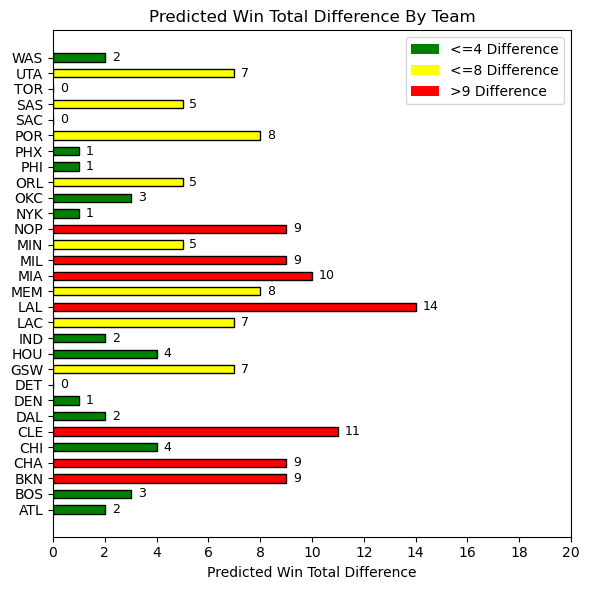

The chart above displays the absolute difference between actual and predicted win totals for each NBA team during the 2022–2023 season. Each bar represents the prediction error in wins for a single team, and the bars are color-coded by magnitude of the difference:

Green: prediction error ≤ 4 wins (strong accuracy)
Yellow: error between 5 and 8 wins (moderate accuracy)
Red: error > 9 wins (significant deviation)
The results show that the majority of teams fall into the green and yellow categories, suggesting that the Markov chain-based simulator is reasonably effective at forecasting season outcomes. Notably accurate predictions include teams like TOR, SAC, DET, and ATL, all of which had 0–2 win difference from their actual records.

However, several teams show large discrepancies — such as the Lakers (14 wins off), Cavaliers (11), and multiple 9+ win deviations. These likely stem from real-world complexities not captured by the simulation, such as mid-season roster changes, injuries, or outperforming preseason expectations. The model is entirely transition-based, so it doesn’t account for player-level dynamics or strength of schedule effects, which may explain some of the variance.

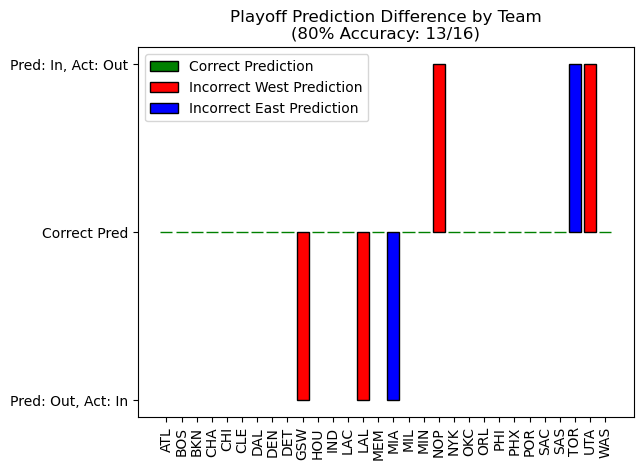

This bar chart illustrates the accuracy of my 2022-23 NBA playoff team predictions by comparing the predicted playoff teams to the actual ones, team by team. Each team is plotted along the x-axis, while the y-axis shows whether the prediction was correct (zero height) or incorrect (non-zero bar).

Green bar at y=0 represents a correct prediction (predicted in playoffs and actually made it, or predicted out and missed).
Red bars indicate incorrect predictions for Western Conference teams:
Positive bars: Predicted in, but the team missed the playoffs
Negative bars: Predicted out, but the team made the playoffs
Blue bars reflect incorrect predictions for Eastern Conference teams, using the same vertical logic.
The green dashed line at y=0 marks a “perfect prediction” baseline.

Overall, the model achieved 80% accuracy, correctly predicting 13 out of 16 playoff teams — with 7/8 accurate picks in the East and 6/8 in the West. This performance demonstrates strong predictive validity, especially across conferences.

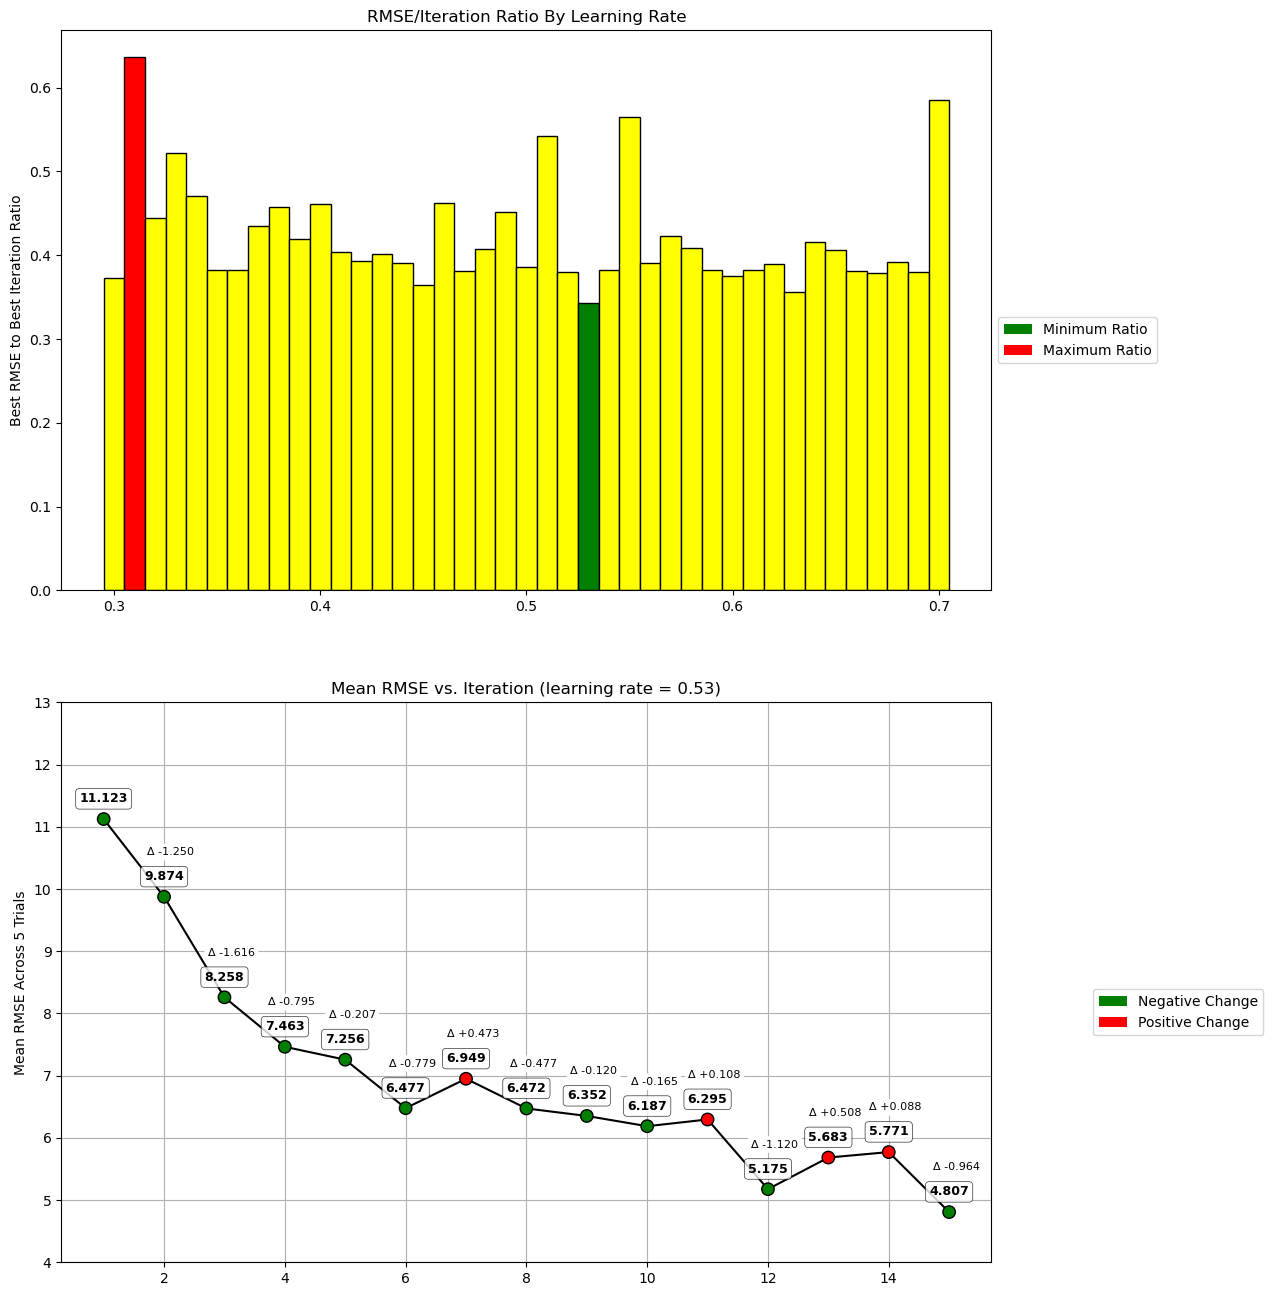

The two graphs above illustrate the process of tuning the learning rate and evaluating convergence behavior across simulation iterations.

In the top chart, each bar represents the ratio of the best RMSE achieved to the iteration it occurred at, for a given learning rate. A lower ratio indicates that the model reached its best performance later in the iteration schedule, which is desirable — it implies a gradual, consistent decline in error, rather than a sharp early drop that may lead to instability or overfitting. The green-highlighted bar corresponds to the optimal learning rate, approximately 0.53, which yielded the most stable and sustained improvement across trials. The red bar highlights a learning rate that overfit early (0.30), leading to a low iteration count but high RMSE.

The bottom chart shows the mean RMSE across 5 trials for each iteration at this optimal learning rate. RMSE consistently declines through the first 10–12 iterations, with minimal volatility thereafter. Each point is annotated with its value and the change (∆) from the previous iteration — green points indicate continued improvement, while red points show minor regressions, which are typical as the model stabilizes. The fact that the RMSE remained below 6 after iteration 10 and continued to decline further validates the stability of the learning process at this rate.

Together, these plots demonstrate that the selected learning rate of 0.53 leads to a reliable and non-parabolic optimization curve, ideal for maintaining consistency across repeated simulations. This tuning was crucial to ensuring that the simulation outcomes weren't overly sensitive to iteration count or random variation.

---
# Timing Results

The full processing pipeline was benchmarked on both a local development machine and Michigan State University's High-Performance Computing Cluster (HPCC). The local environment used **4 `ProcessPoolExecutor` workers**, each coordinating **4 threads**, while the HPCC ran with **27 workers** (with 4 threads each) for the first two stages and **8 workers** for the final step with no threading.

| Stage                   | Local Time (4 Proc × 4 Threads) | HPCC Time (28 Proc × 4 Threads) | Speedup |
|-------------------------|----------------------------------|----------------------------------|---------|
| `year_processing.py`    | 83 seconds                       | ~15 seconds                       | ~5.5×     |
| `pbp_processing.py`     | 538 seconds                      | ~77 seconds                      | ~7×     |
| `team_probabilities.py` | 137 seconds                      | ~41 seconds                       | ~3.3×   |

These results show **near-linear scalability** in the first two preprocessing stages, thanks to their structure being inherently parallelizable at the season level. Each season's play-by-play data is processed independently, making them ideal candidates for embarrassingly parallel workloads.

The second stage, `pbp_processing.py`, includes more complex logic for possession segmentation and contextual tagging but still benefits heavily from multiprocessing at the season level. Despite the additional computation, its performance improvement matched that of the first stage on the HPCC.

The final stage, `team_probabilities.py`, also benefits from parallelism, but the speedup is slightly sublinear. This is likely due to heavier I/O operations and the memory-bound nature of matrix transformations and data shuffling, as each worker processes grouped possession data across teams.

Still, reducing runtime from **over 12 minutes locally to under 2.5 minutes** on the HPCC demonstrates the effectiveness of parallelization. The results validate both the design of the codebase and the substantial time savings achieved by scaling across more CPU cores.

---
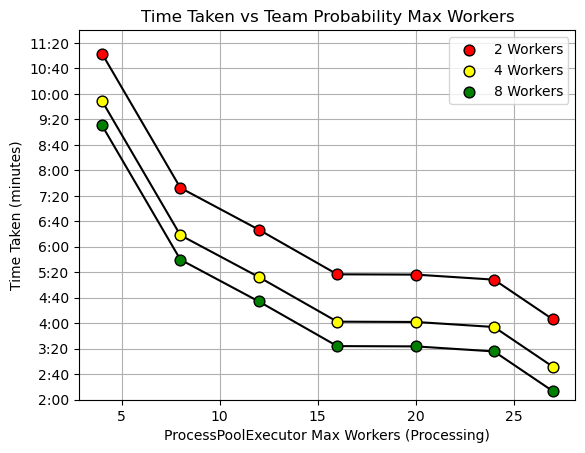

The chart above shows the total pipeline execution time for varying degrees of parallelism in each stage. The first two stages (year_processing.py and pbp_processing.py) scale linearly up to 27 process workers, each with 4 threads, peaking at 108 concurrent threads. The third stage (team_probabilities.py) does not use threading and varies between 2 to 8 process workers depending on system load and data availability (typically the last 8 seasons).
Despite this difference in architecture, we observe consistent and impressive improvements in total execution time. This demonstrates that the pipeline design balances memory, I/O, and CPU workloads efficiently across its stages. The results show that both multi-threading and multi-processing were leveraged effectively, with the Markov chain simulation phase showing especially good responsiveness to increases in process parallelism.

---
# Concluding Discussion and Future Work

This project simulated an NBA season using possession-level Markov chains built from over two decades of play-by-play data, with accuracy evaluated by predicted win totals and model tuning optimized via parallel computing. The simulation’s objective was to approximate team performance in the 2022–2023 NBA season by leveraging team-specific transition probabilities and start-type distributions in realistic game scenarios. Parallelism was utilized at multiple stages, including game-level simulation and seasonal matrix generation, to significantly reduce computational overhead.

The results demonstrate reasonable predictive performance: half of the teams had a win total error of four or fewer, as shown in the horizontal bar chart of prediction errors. However, a few outliers (e.g., LAL, CLE, MIL) had larger deviations, suggesting that real-world variability like injuries, roster changes, or coaching adjustments may not be fully captured by transition probabilities alone. These high-difference teams highlight areas for future enhancement, possibly by integrating dynamic player-level data or lineup effects.

On the optimization front, a grid search across learning rates revealed a clear optimal region around 0.53, balancing convergence speed and final accuracy. The RMSE/iteration ratio plot and RMSE trajectory graph illustrate the iterative tuning process. Lower learning rates underfit, while overly aggressive rates spiked early before stabilizing poorly. By selecting a balanced rate and averaging performance over multiple trials, the simulation achieved consistent convergence with reduced variance, showcasing the importance of stability in stochastic simulations.

Looking forward, the simulation could be expanded to include player-specific effects, injury modeling, or real-time adaptation of probabilities. Additionally, it could be applied to generate “what-if” scenarios, power rankings, or betting models. More sophisticated parallel strategies, such as Dask clusters or GPU-based sampling, may also further improve efficiency. This project not only deepened my understanding of both basketball analytics and parallel design but also demonstrated how domain-specific models benefit from scalable computing techniques.

---
# References

- Kaggle NBA Play-by-Play Dataset. Available at: [https://www.kaggle.com/datasets](https://www.kaggle.com/datasets)  
  *(Used for all `pbp_YEAR.csv` raw data files processed through `year_processing.py`)*

- Peter Beshai (2016). *Buckets: NBA Shot Visualization*.  
  Retrieved from: [https://peterbeshai.com/buckets/](https://peterbeshai.com/buckets/)  
  *(Used for motivating image showing shot distribution patterns)*


----